<a href="https://colab.research.google.com/github/980608/Portfolio/blob/main/%ED%9A%8C%EC%82%AC%20%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/%E3%88%9C%EC%97%91%EC%8A%A4%ED%94%8C%EB%9D%BC%EC%9D%B4%EC%96%B4/%EB%A9%94%EB%89%B4%ED%8C%90_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터가 있는 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 메뉴판 이미지 ZOOM code

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import ImageFont, ImageDraw,Image

In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype='float32')
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    return rect

In [ ]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype='float32')

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [ ]:
def correct_rotation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image

    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[-1]

    if angle < -45:
        angle += 90
    elif angle > 45:
        angle -= 90

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated

In [ ]:
def resize_menu_board(image_path, scale=1.0):
    # 이미지 로드
    image = cv2.imread(image_path)
    roi_img = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 블러 적용하여 노이즈 제거
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 기존 방식으로 Canny 엣지 검출 적용
    edges = cv2.Canny(blurred, 50, 100)

    # 모폴로지 변환을 통해 노이즈 제거 및 윤곽 강조
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 윤곽선 찾기
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_candidate = None
    max_area = 0

    # 네모난 객체 찾기 (크기 및 비율 필터링)
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:  # 네모난 모양
            area = cv2.contourArea(approx)
            if area > 5000 and area > max_area:  # 가장 큰 사각형 선택
                max_area = area
                best_candidate = approx

    if best_candidate is not None:
        warped = four_point_transform(image, best_candidate.reshape(4, 2))
        rotated = correct_rotation(warped)  # 추가된 회전 보정 단계

        # 메뉴판 확대
        menu_resized = cv2.resize(rotated, (int(rotated.shape[1] * scale), int(rotated.shape[0] * scale)))

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create subplots

        axes[0].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB)) #Original Image, Convert color space for plt.imshow
        axes[0].set_title('Original')
        axes[0].axis('off')

        axes[1].imshow(cv2.cvtColor(menu_resized, cv2.COLOR_BGR2RGB)) #Zoomed Image, Convert color space for plt.imshow
        axes[1].set_title('ZOOM')
        axes[1].axis('off')
        # 결과 이미지
        #plt.imshow(['Original','ZOOM'],[roi_img, menu_resized], figsize=(16,10)) # plt.imshow로 이미지 출력
        #plt.axis('off')
        #plt.show()
        cv2.imwrite("/content/drive/MyDrive/test_img/6_1.png",menu_resized)

    else:
        print("이미지를 다시 촬영해 주세요.")

# 메뉴판 이미지 ZOOM code 실행

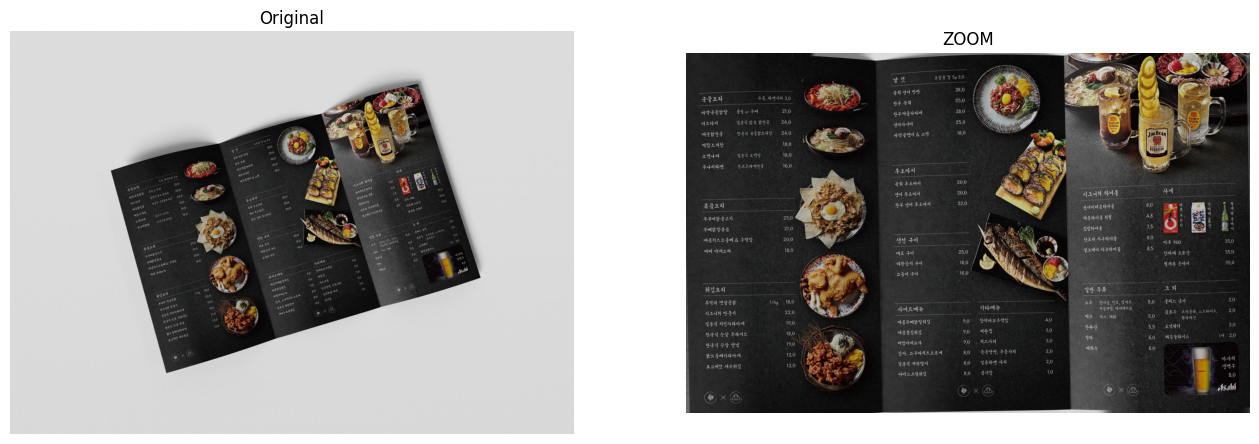

In [ ]:
resize_menu_board("/content/drive/MyDrive/test_img/6.jpg")

# OCR 설명 자료
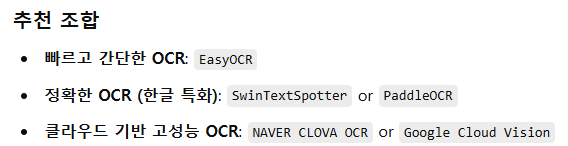
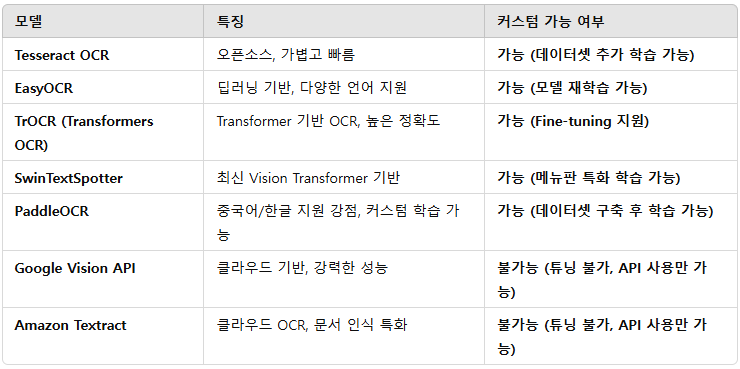

# PaddleOCR 모델 사용 방법

In [ ]:
!pip install paddleocr
!pip install paddlepaddle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a144adbc8b7e5c9d113b0a6d46a743be9d5dee597408530b1e23125396729147
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found e

In [ ]:
import cv2
from paddleocr import PaddleOCR, draw_ocr # 설치가 필요한 라이브러리
#from utils.image_util import plt_imshow, put_text
from paddleocr.paddleocr import MODEL_URLS
import platform

In [ ]:
class PaddleOCR_model:
    # 모델 언어 선택(한국어)
    def __init__(self, lang : str = 'korean',**kwargs):
        self.lang = lang
        self._ocr=PaddleOCR(lang="korean")
        self.img_path = None
        self.ocr_result = {}

    def get_available_langs(self):
        langs_info = []

        for idx, model_name in enumerate(list(MODEL_URLS['OCR'].keys())):
            for lang in list(MODEL_URLS['OCR'][model_name]['rec'].keys()):
                if lang not in langs_info:
                    langs_info.append(lang)

        print(f'Available Language : {langs_info}')

    def get_available_models(self):
        model_info = {}

        for idx, model_name in enumerate(list(MODEL_URLS['OCR'].keys())):
            model_info[model_name] = list(MODEL_URLS['OCR'][model_name]['rec'].keys())
            print(f'#{idx+1} Model Vesion : [{model_name}] - Language : {list(MODEL_URLS["OCR"][model_name]["rec"].keys())}')

    def get_ocr_result(self):
        return self.ocr_result

    def get_img_path(self):
        return self.img_path

    def show_img(self):
        plt_imshow(self.img_path) # Corrected img_self to self.

    def run_ocr(self,img_path: str,debug :bool =False):
        self.img_path = img_path
        ocr_text = []
        result = self._ocr.ocr(img_path, cls =False)
        self.ocr_result = result[0]

        if self.ocr_result : # Corrected ocr_resullt to ocr_result
            for r in result[0]:
                ocr_text.append(r[1][0])
        else:
            ocr_text = 'No text detected'

        if debug:
            self.show_img_with_ocr()

        return ocr_text

    def show_img_with_ocr(self): # 좌표값 가져오는 함수
        img = cv2.imread(self.img_path)
        roi_img = img.copy()

        for text_result in self.ocr_result:
            text = text_result[1][0]

            topLeft = (int(text_result[0][0][0]), int(text_result[0][0][1]))
            topRight = (int(text_result[0][1][0]), int(text_result[0][1][1]))
            bottomRight = (int(text_result[0][2][0]), int(text_result[0][2][1]))
            bottomLeft = (int(text_result[0][3][0]), int(text_result[0][3][1]))

            cv2.line(roi_img, topLeft, topRight, (0,255,0),2)
            cv2.line(roi_img, topRight, bottomRight, (0,255,0),2)
            cv2.line(roi_img, bottomRight, bottomLeft, (0,255,0),2)
            cv2.line(roi_img, bottomLeft, topLeft, (0,255,0),2)
            roi_img = put_text(roi_img, text, topLeft[0],topLeft[1] - 20, font_size = 10)

            print(text)

        plt_imshow(['Original','ROI'],[img, roi_img], figsize=(16,10))

In [ ]:
def plt_imshow(title = 'image', img=None,figsize=(8,5)): #changed figsize parameter
    plt.figure(figsize=figsize)

    if type(img) is str:
        img = cv2.imread(img)

    if type(img) == list:
        if type(title)== list:
            titles = title

        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)


        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i],cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i],cv2.COLOR_BGR2RGB)


            plt.subplot(1, len(img),i+1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]),plt.yticks([])

        plt.show()

    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) #fixed index error
        else:
            rgbImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #fixed index error

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]),plt.yticks([])
        plt.show()

In [ ]:
def put_text(image, text,x,y,color=(0,0,0), font_size=22):
    if type(image) == np.ndarray:
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(color_coverted)

    #if platform.system() == 'Darwin':
    #    font = 'AppleGothic.ttf'
    #elif platform.system() == 'Windows':
    #    font = 'malgun.ttf'
    font = "/content/public/static/Pretendard-Light.otf"
    image_font = ImageFont.truetype(font,font_size) # corrected name image_fornt to image_font
    #font = ImageFont.load_default() # Removed, this line caused the error
    draw = ImageDraw.Draw(image)

    draw.text((x,y),text, font=image_font,fill=color) # corrected name image_fornt to image_font

    numpy_image = np.array(image)
    opencv_image = cv2.cvtColor(numpy_image,cv2.COLOR_BGR2RGB)

    return opencv_image

In [ ]:
!unzip -qq '/content/drive/MyDrive/Pretendard-1.3.9.zip' -d '/content/'

[2025/03/12 08:21:59] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch

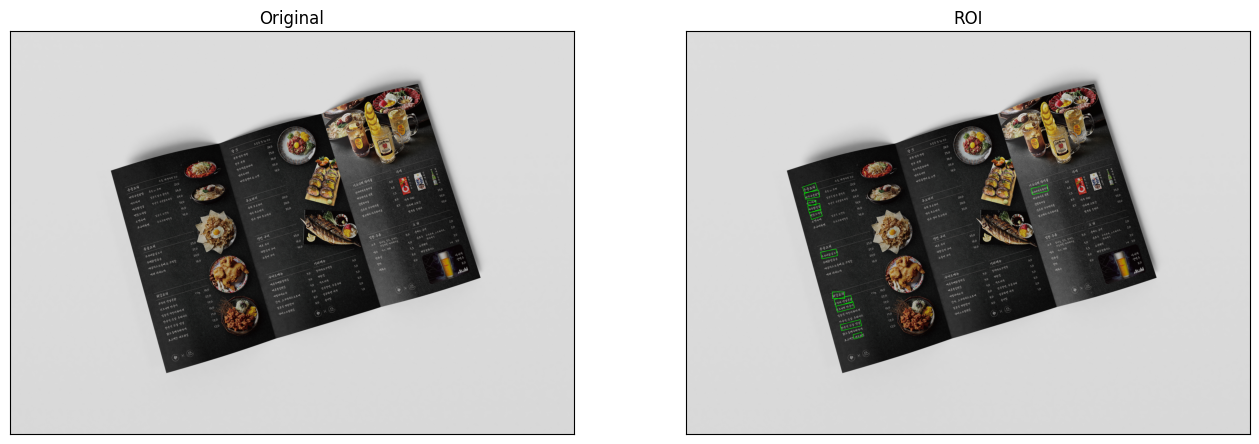

['국물요리',
 '러미레몽하이플',
 '마악국물닭빌',
 '즈라키',
 '미운닮전공',
 '결합조재',
 '푸우미맑붙고기',
 '튀김요리',
 '주억의옛날종',
 '1즈너척간풍기',
 '한국식순살양님',
 '사우뮈']

In [ ]:
ocr = PaddleOCR_model()
img_path = '/content/drive/MyDrive/test_img/6.jpg'
ocr.run_ocr(img_path, debug=True)

[2025/03/12 08:22:46] ppocr DEBUG: dt_boxes num : 167, elapsed : 0.22151517868041992
[2025/03/12 08:23:01] ppocr DEBUG: rec_res num  : 167, elapsed : 14.873435974121094
날것
초밤용밥520
육회연어반반
280
국물요리
무동
라멘사리20
250
한우육회
마약국물닭발
콜림아무백
210
280
한우치플타라끼
미즈키
일본식맑은닭건골
240
250
연어사시미
미운닭전골
한국식
국물닭도리랑
240
마악골뱅이&소면
180
60
JM BEAy
뱍합조지랑
180
B00R90거
오펭나베
일본식오펭딩
180
부나비라멘
돈코크라멘전골
6
후토마키
육회후로마기
200
연어후토마키
200
시그너쳐
하이볼
볶음요리
환우연어우로마기
220
산러미레몽하이볼
80
230
레몬하이불리필
+8
주꾸미닭불고기
210
짐빔하이볼
15
무려긁발볶음
미콤치즈오동력&주먹밥
200
주이
산로리
가쿠하이볼
80
생원
마루900
350
얼그레이가쿠하이봉
85
래책야끼소바
180
주이
250
간바레오포상
350
에로
지왕심치구이
180
월계관
준마이
350
고등어구이
16
튀김요리
일반
추류
그
오
옛날롱
11
180
짬이술진로일시주
50
쿨피스
문거
2
추억의
소주
사이드메뉴
기타메뉴
처음처럼아이서이슬
220
음로수
코카롤라
스프라이트
20
시그너쳐
맥주
카스레라
50
환화화인
190
미콤무발뮈김
90
참치마요주먹밥
일본식
치킨가라아게
한라신
55
토닉워터
20
180
미콤짐휘김
90
후라이드
계린쯤
한국식
순살
청하
60
레몬슬라이스
20
90
치즈사리
30
한국식순살양념
19
비빔야끼교자
마미화수
중국당면
우동사리
5C
닭오돌벽가라아게
120
감자
고구마치즈고로커
3
*것'
아사히
120
일본식계란말이
80
일본라멘사리
표고버첫
시우튀
성맥주
아이스크림뤄
80
공기밥
80
Asahi
'5


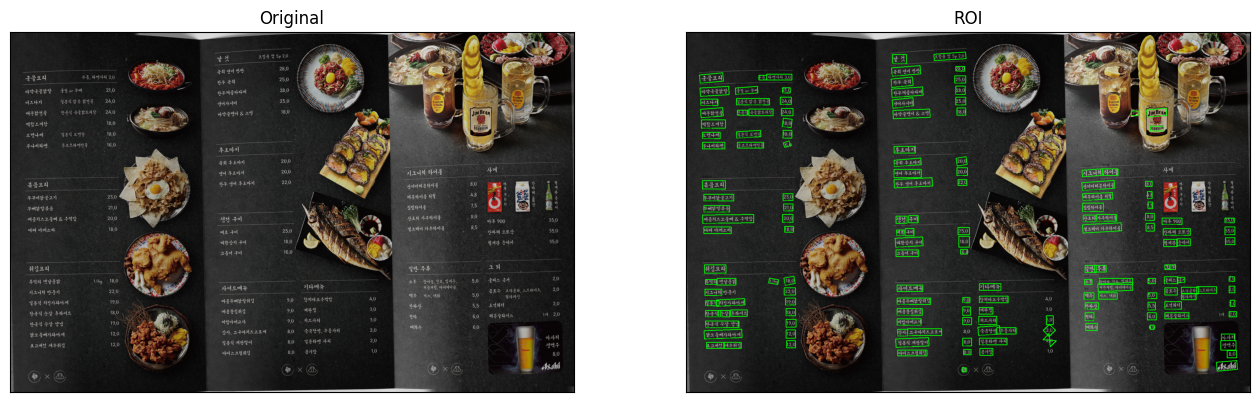

['날것',
 '초밤용밥520',
 '육회연어반반',
 '280',
 '국물요리',
 '무동',
 '라멘사리20',
 '250',
 '한우육회',
 '마약국물닭발',
 '콜림아무백',
 '210',
 '280',
 '한우치플타라끼',
 '미즈키',
 '일본식맑은닭건골',
 '240',
 '250',
 '연어사시미',
 '미운닭전골',
 '한국식',
 '국물닭도리랑',
 '240',
 '마악골뱅이&소면',
 '180',
 '60',
 'JM BEAy',
 '뱍합조지랑',
 '180',
 'B00R90거',
 '오펭나베',
 '일본식오펭딩',
 '180',
 '부나비라멘',
 '돈코크라멘전골',
 '6',
 '후토마키',
 '육회후로마기',
 '200',
 '연어후토마키',
 '200',
 '시그너쳐',
 '하이볼',
 '볶음요리',
 '환우연어우로마기',
 '220',
 '산러미레몽하이볼',
 '80',
 '230',
 '레몬하이불리필',
 '+8',
 '주꾸미닭불고기',
 '210',
 '짐빔하이볼',
 '15',
 '무려긁발볶음',
 '미콤치즈오동력&주먹밥',
 '200',
 '주이',
 '산로리',
 '가쿠하이볼',
 '80',
 '생원',
 '마루900',
 '350',
 '얼그레이가쿠하이봉',
 '85',
 '래책야끼소바',
 '180',
 '주이',
 '250',
 '간바레오포상',
 '350',
 '에로',
 '지왕심치구이',
 '180',
 '월계관',
 '준마이',
 '350',
 '고등어구이',
 '16',
 '튀김요리',
 '일반',
 '추류',
 '그',
 '오',
 '옛날롱',
 '11',
 '180',
 '짬이술진로일시주',
 '50',
 '쿨피스',
 '문거',
 '2',
 '추억의',
 '소주',
 '사이드메뉴',
 '기타메뉴',
 '처음처럼아이서이슬',
 '220',
 '음로수',
 '코카롤라',
 '스프라이트',
 '20',
 '시그너쳐',
 '맥주',
 '카스레라',
 '50',
 '환화화인',
 '190',
 '미콤무발뮈김',

In [ ]:
img_path = '/content/drive/MyDrive/test_img/6_1.png'
ocr.run_ocr(img_path, debug=True)

# SwinTextSpotter OCR 사용방법
- 메뉴판 판독에 특화 된 모델
- 데이터를 추가하여 학습 할 수 있음
- 라벨링 작업이 필요하여 시간이 많이 들수 있는 단점 발생
- LabelMe 프로그램으로 라벨링 작업(무료 프로그램)
- 한국어 지원안함 데이터 확보 후 학습 시켜야됨

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# PyTorch 및 관련 라이브러리 설치
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python numpy matplotlib pandas timm shapely Polygon3

# Detectron2 설치 (필수)
!pip install git+https://github.com/facebookresearch/detectron2.git

# SwinTextSpotter 저장소 다운로드
!git clone https://github.com/mxin262/SwinTextSpotter.git
%cd SwinTextSpotter